In [1]:
# prompt: install fastai and pytorch and duckduck go search

!pip install fastai
!pip install duckduckgo_search


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import numpy as np
import pandas as pd

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import *

In [4]:
??DDGS

In [55]:
def search_images(term, max_images=50):
  print(f"Searching for '{term}'")
  return L(DDGS().images(term, max_results = max_images)).itemgot('image')

In [56]:
from fastdownload import download_url
from fastai.vision.all import *

In [54]:
!rm -rf bear_not_bear

In [57]:
searches = 'grizzly bear','black bear', 'teddy bear', 'polar bear'
path = Path('bear_not_bear')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} cartoon photo'))
    sleep(10)


Searching for 'grizzly bear photo'
Searching for 'grizzly bear cartoon photo'
Searching for 'black bear photo'
Searching for 'black bear cartoon photo'
Searching for 'teddy bear photo'
Searching for 'teddy bear cartoon photo'
Searching for 'polar bear photo'
Searching for 'polar bear cartoon photo'


In [58]:
??DataBlock

In [29]:
??verify_images

In [59]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

15

In [65]:
bears = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                item_tfms = Resize(128),
                get_y = parent_label)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


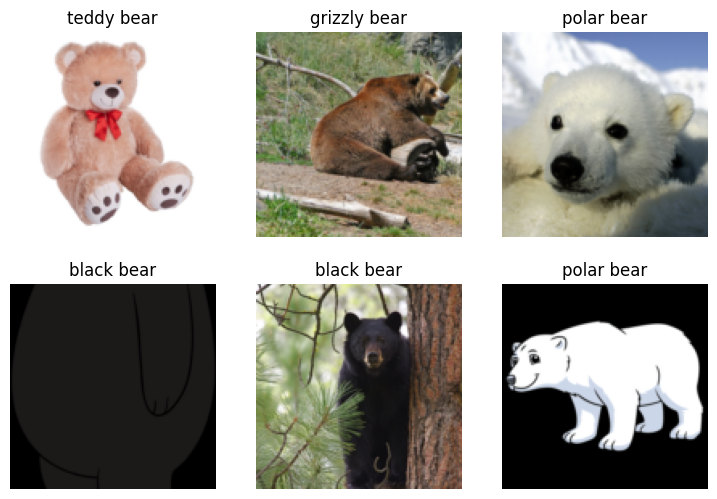

In [67]:
dls = bears.dataloaders(path)
dls.show_batch(max_n=6)

Adding some augmentations to the images

In [68]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))

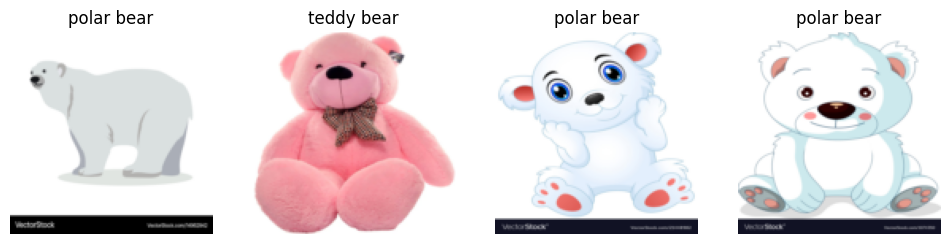

In [69]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Train the vision model

In [70]:
model = vision_learner(dls, resnet18, metrics = error_rate)
model.fine_tune(10)

In [71]:
prediction  = model.predict('polar_bear.jpg')

In [72]:
prediction

('polar bear',
 tensor(2),
 tensor([1.2102e-02, 9.3497e-04, 9.8661e-01, 3.5470e-04]))

In [73]:
prediction  = model.predict('polar_bear_real.jpg')

In [74]:
prediction

('polar bear',
 tensor(2),
 tensor([4.1449e-07, 1.1568e-06, 1.0000e+00, 2.3576e-07]))

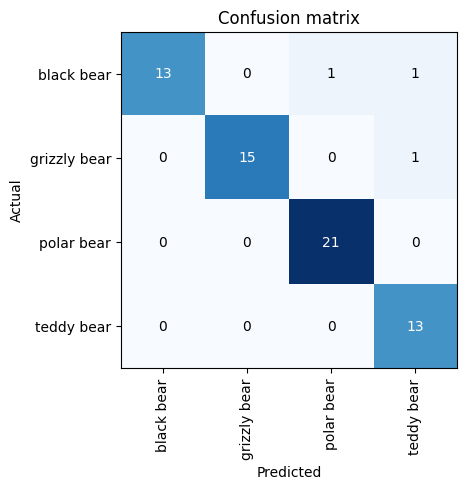

In [75]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

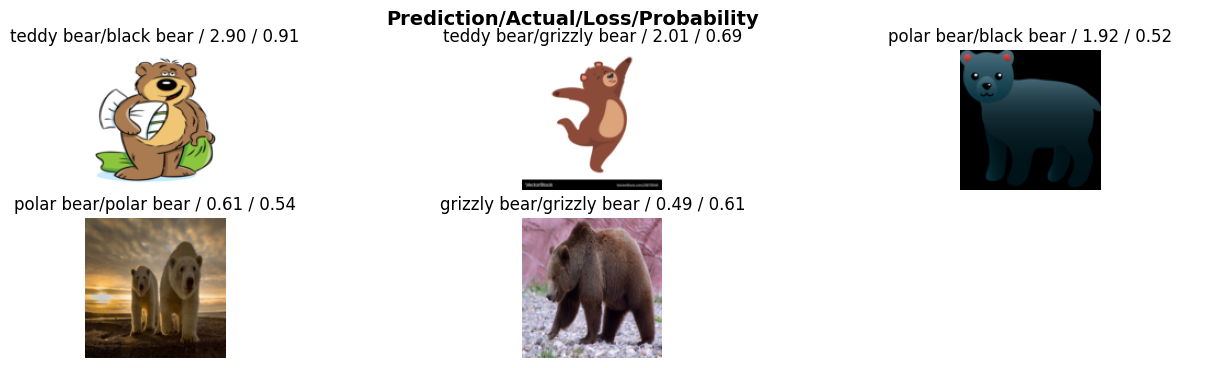

In [76]:
interp.plot_top_losses(range(0,5), figsize=(16,4))

In [79]:
from fastai.vision.widgets import *

In [80]:
??ImageClassifierCleaner

In [82]:
cleaner = ImageClassifierCleaner(learn = model)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [83]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Export the model for deploying it hp production

In [84]:
model.export()